Lamdda: 100000
MSE: 0.07
R2: 0.35


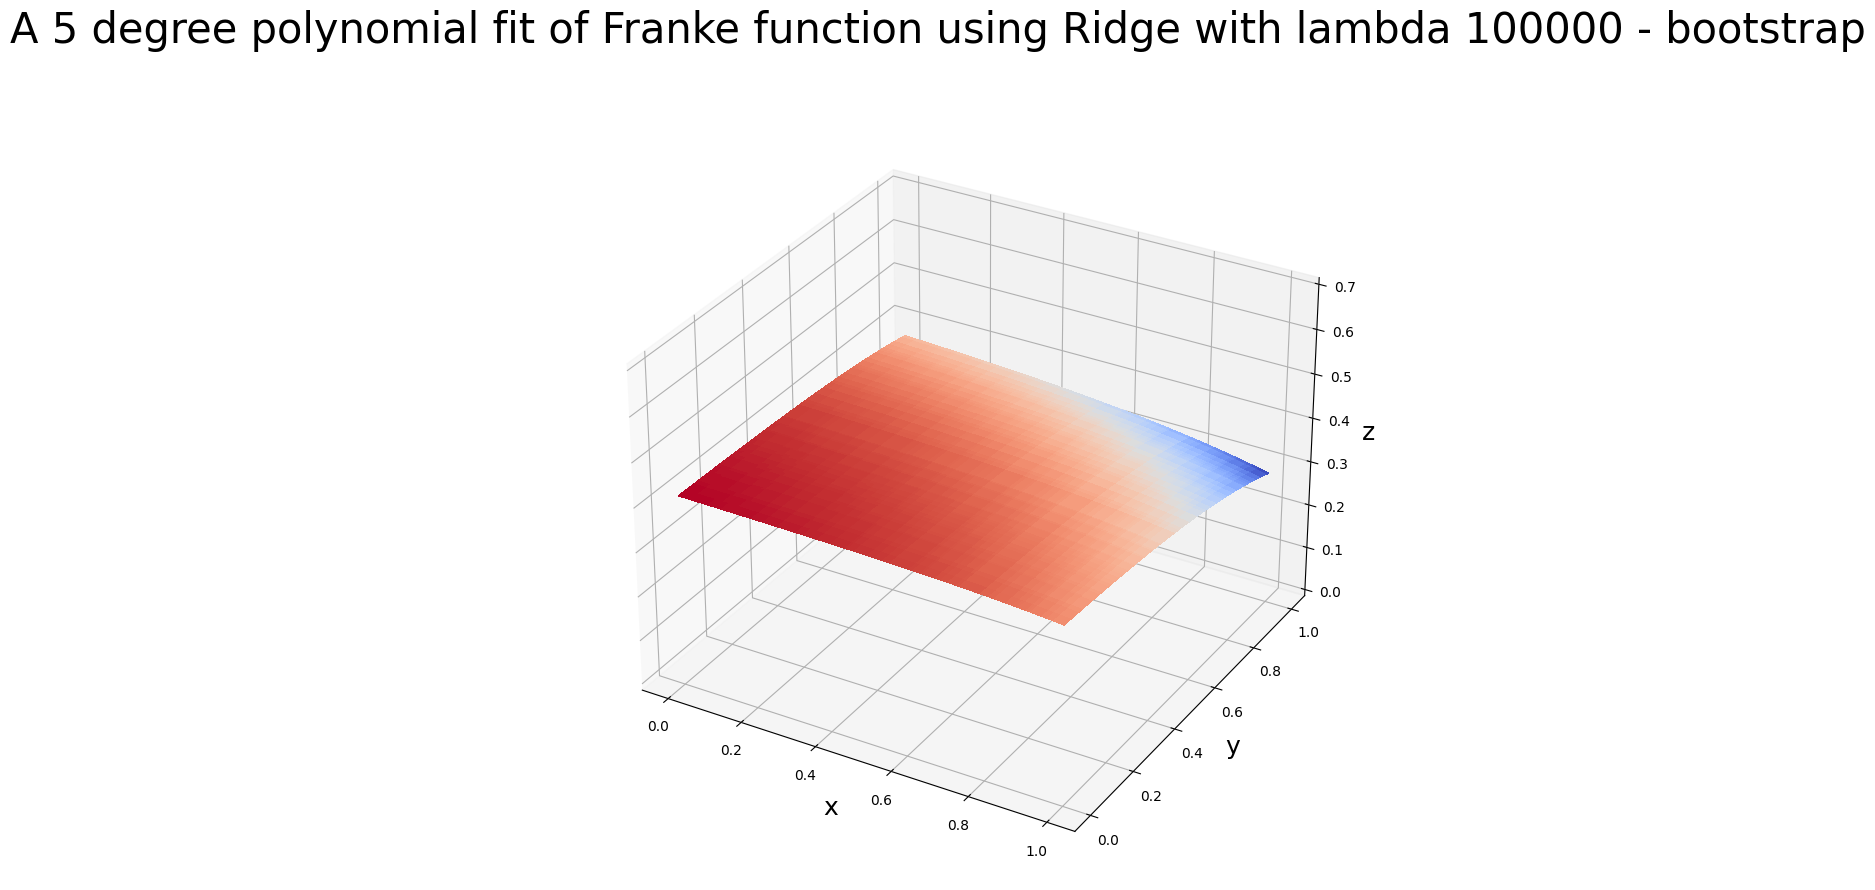

Lamdda: 10000
MSE: 0.05
R2: 0.56


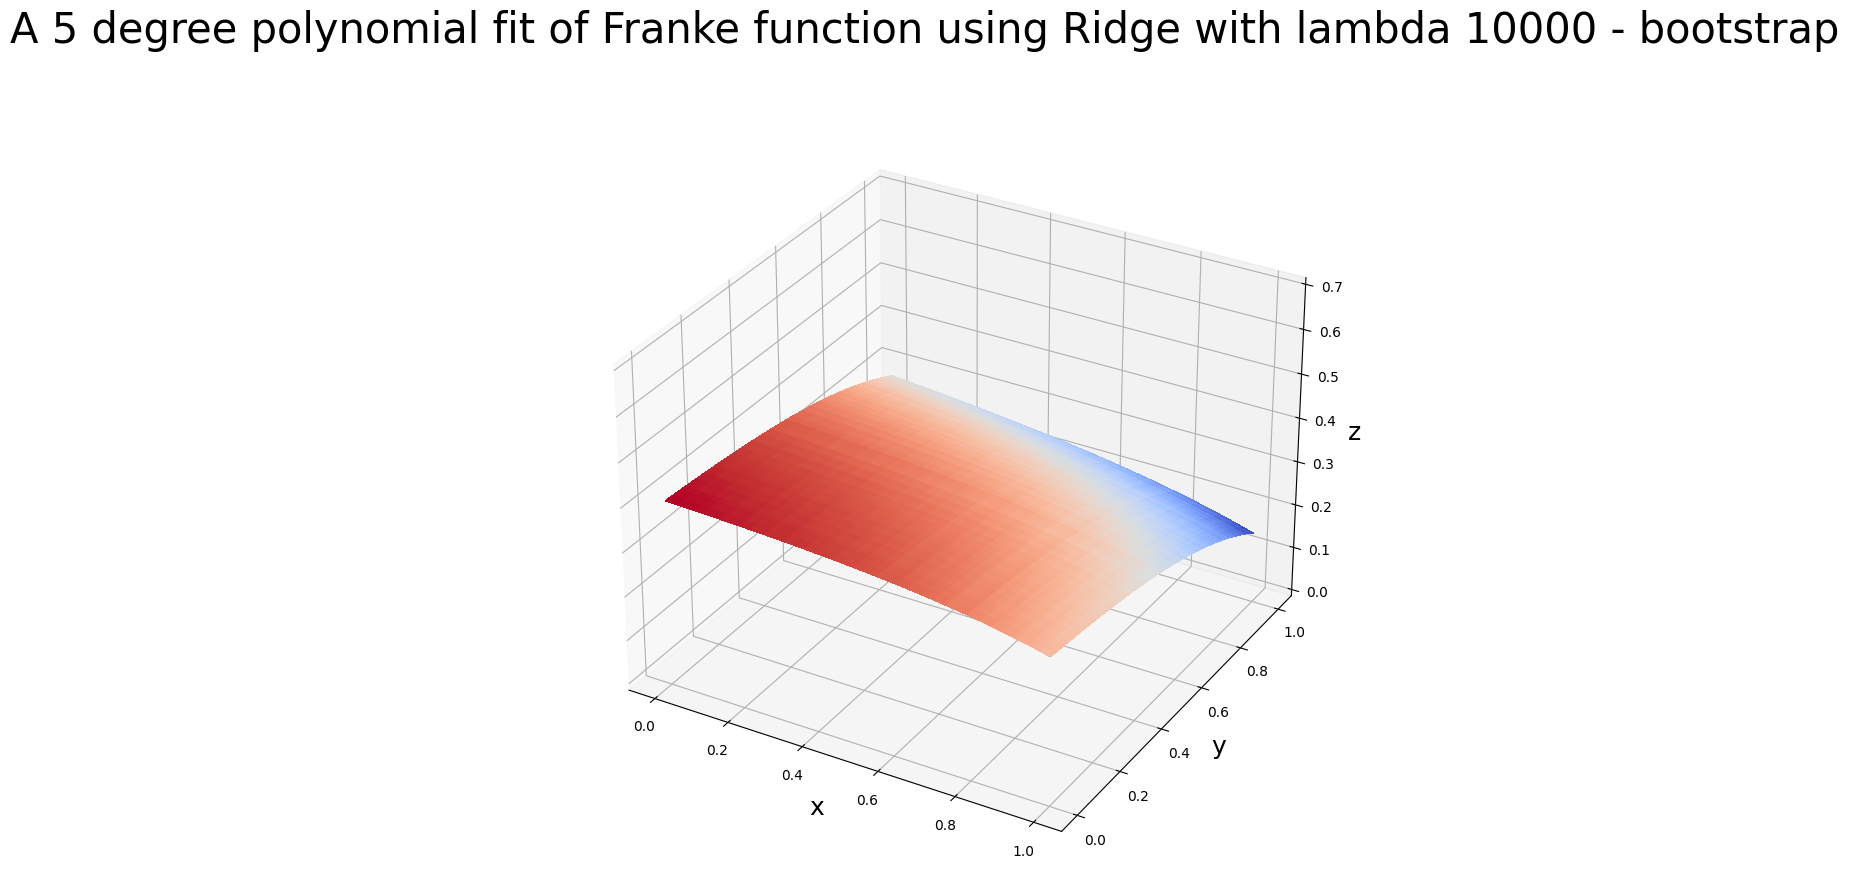

Lamdda: 1000
MSE: 0.03
R2: 0.71


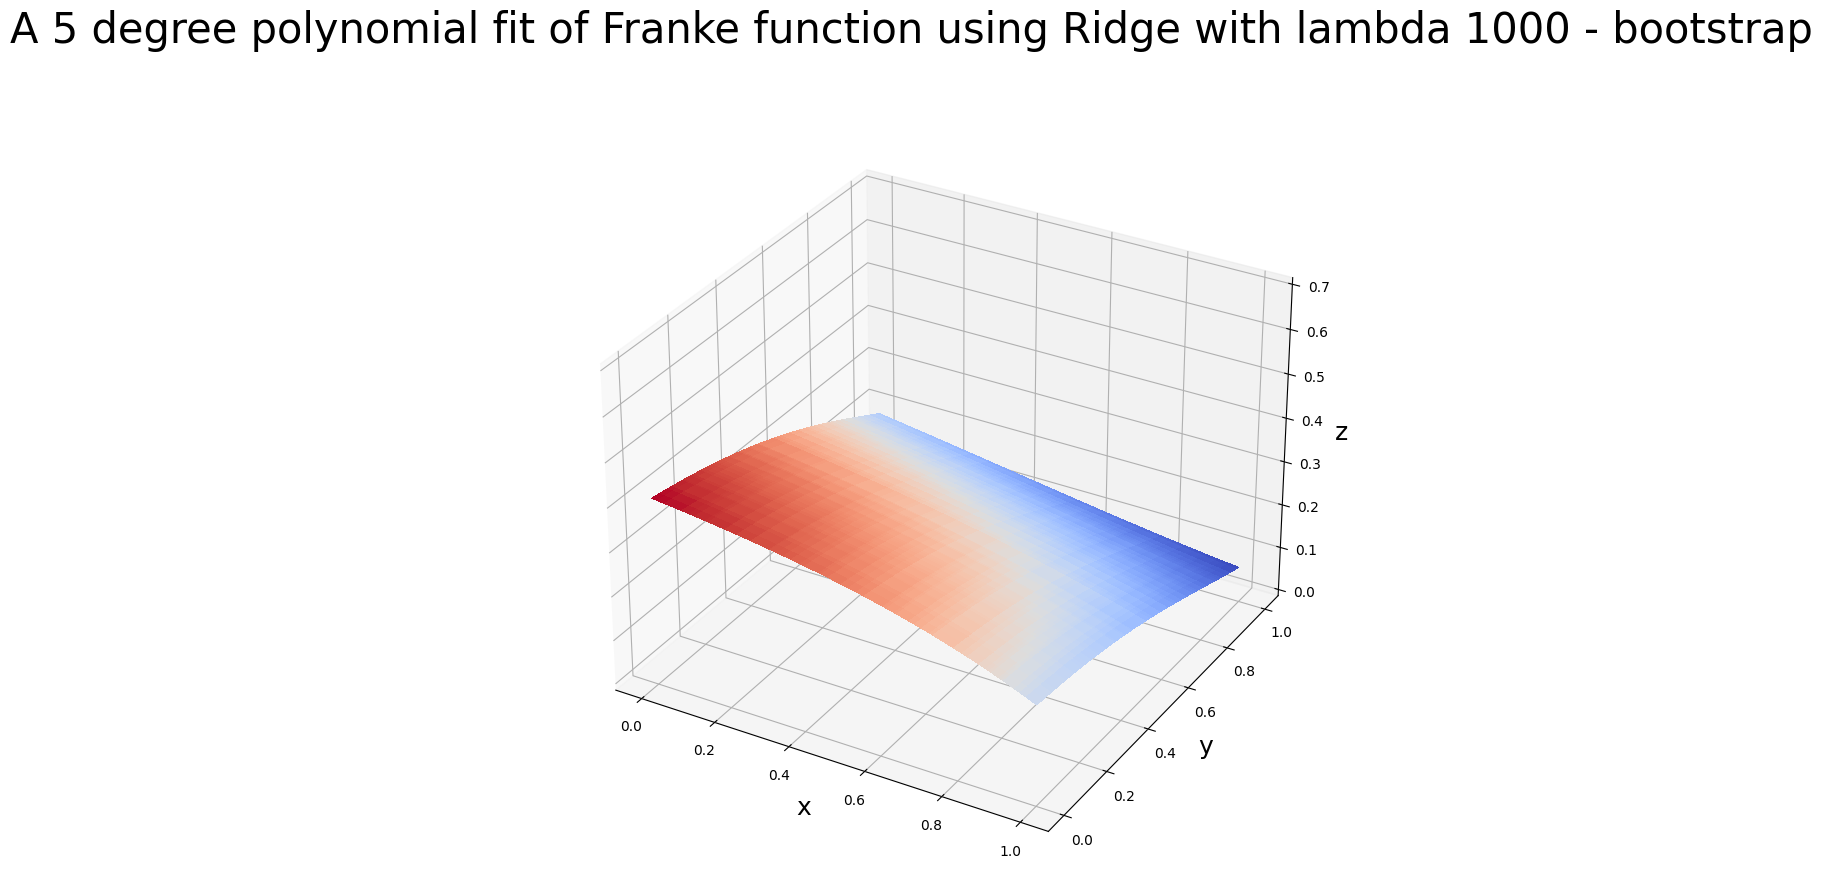

Lamdda: 100
MSE: 0.02
R2: 0.79


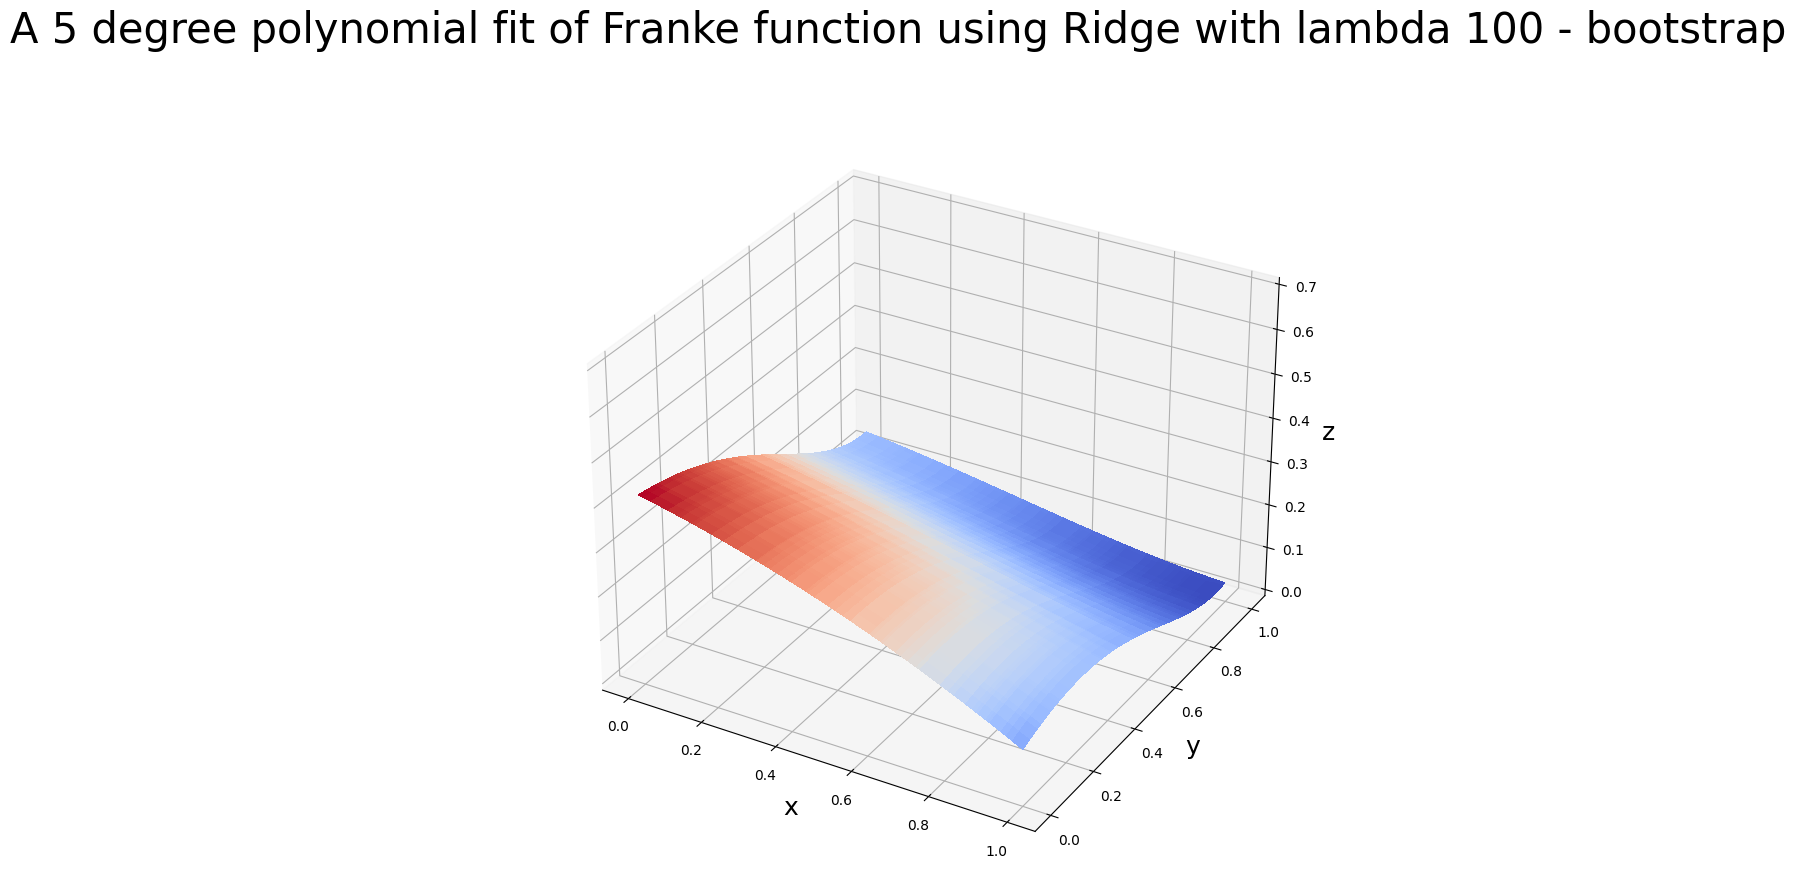

Lamdda: 10
MSE: 0.02
R2: 0.81


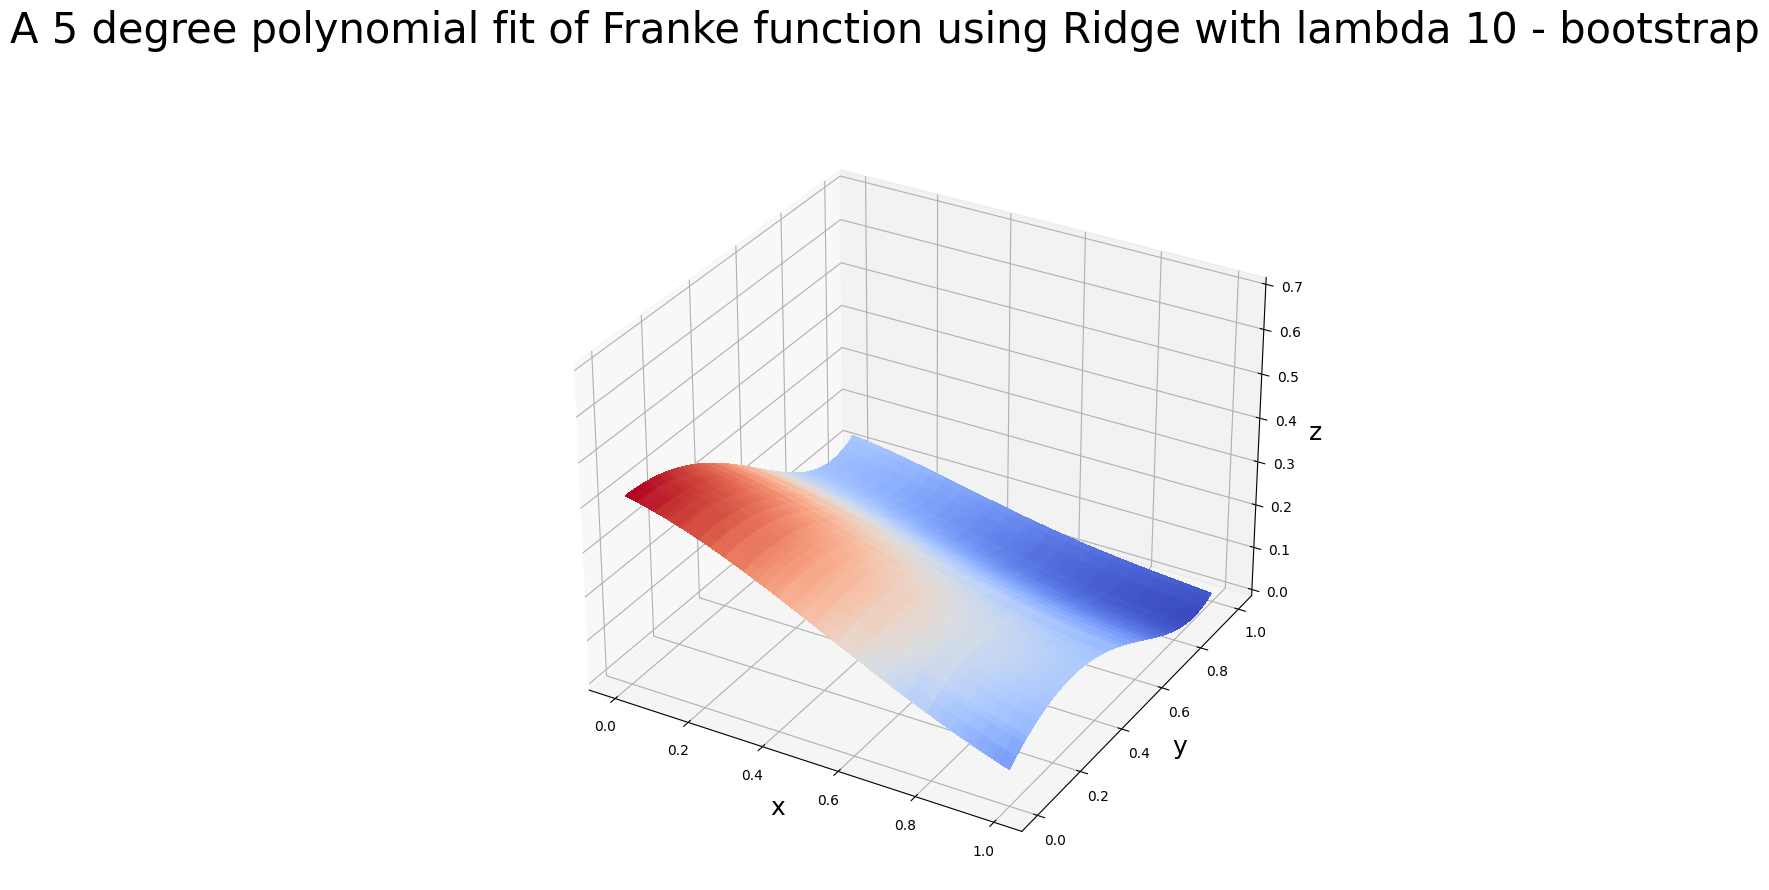

Lamdda: 1
MSE: 0.02
R2: 0.84


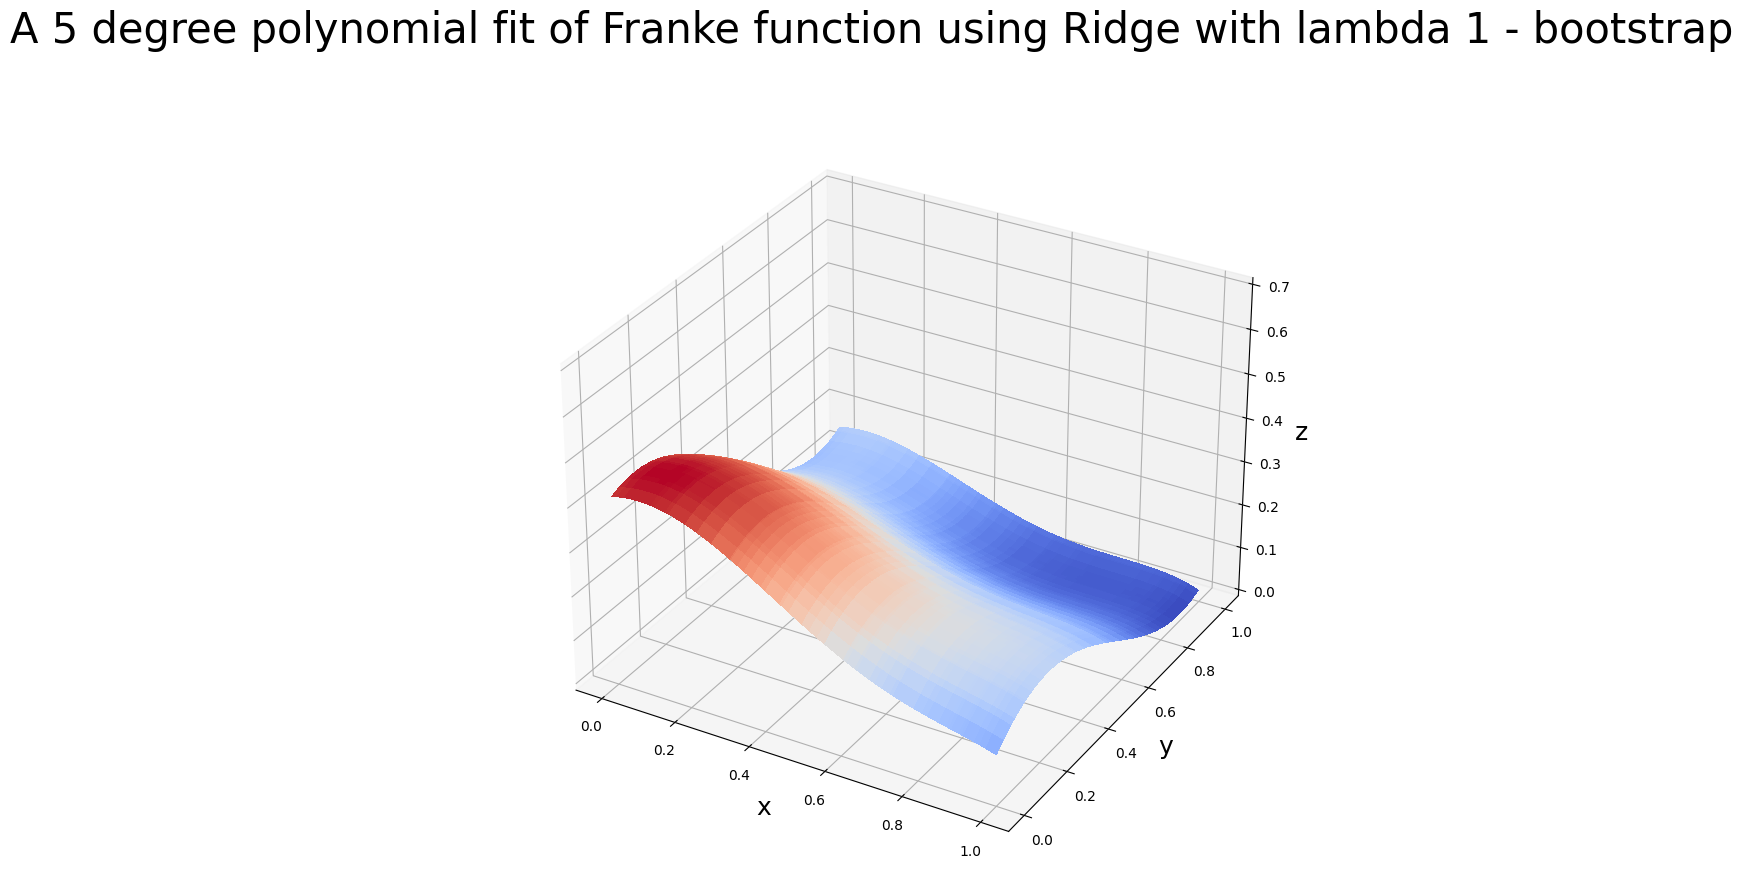

Lamdda: 0.1
MSE: 0.01
R2: 0.86


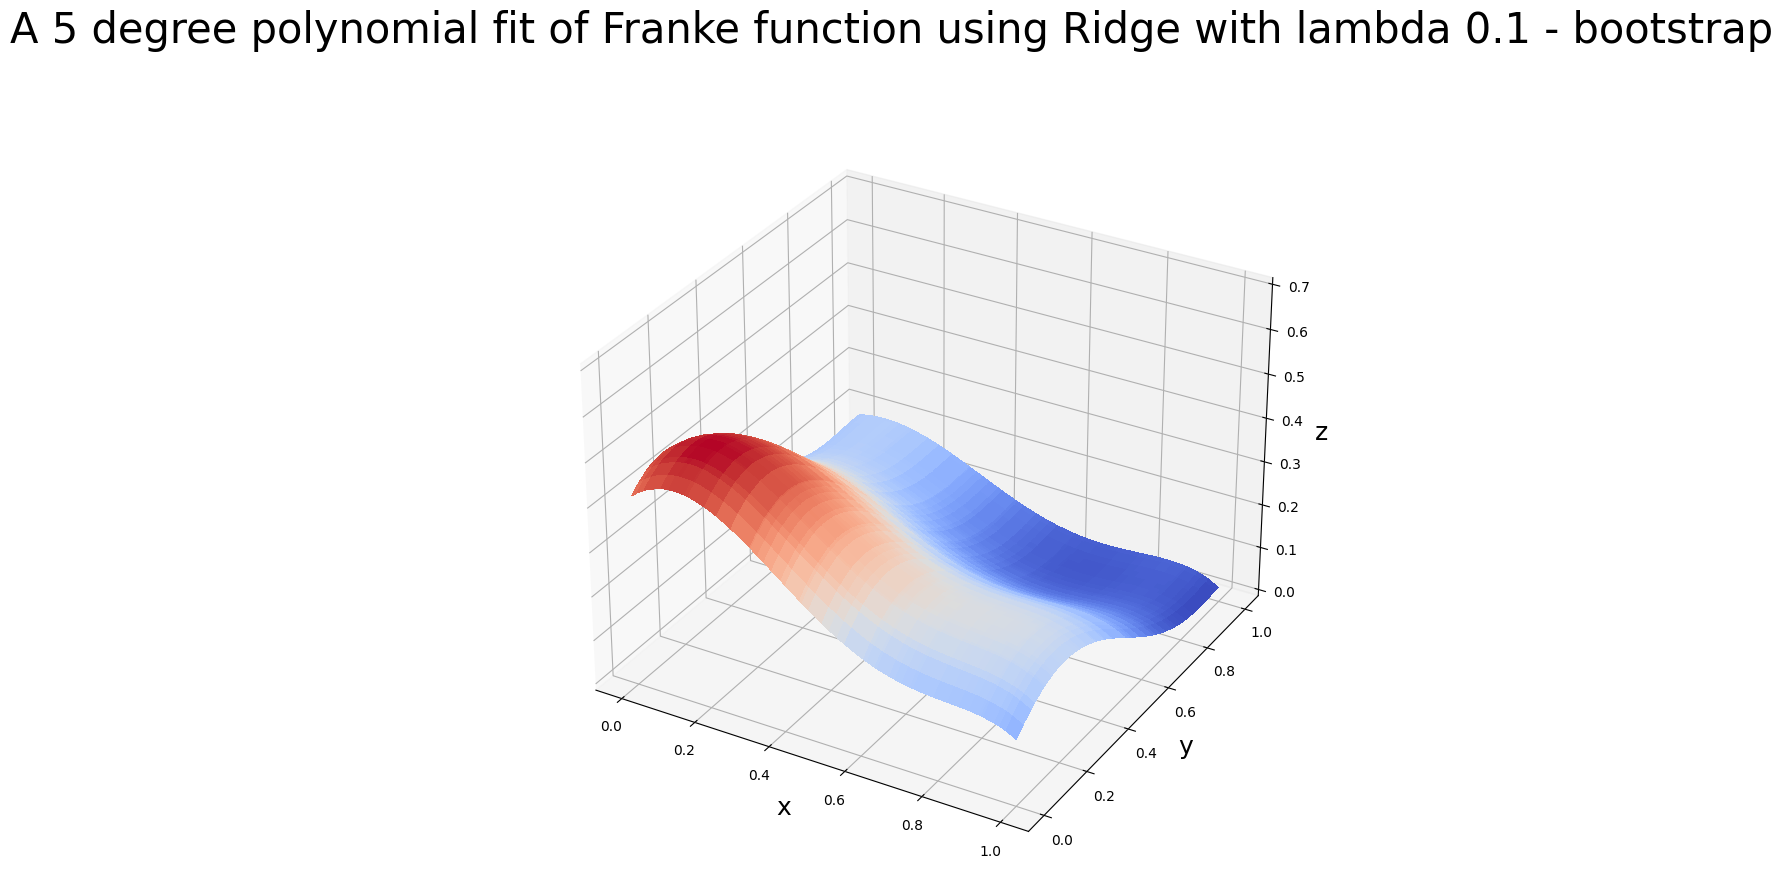

Lamdda: 0.01
MSE: 0.01
R2: 0.88


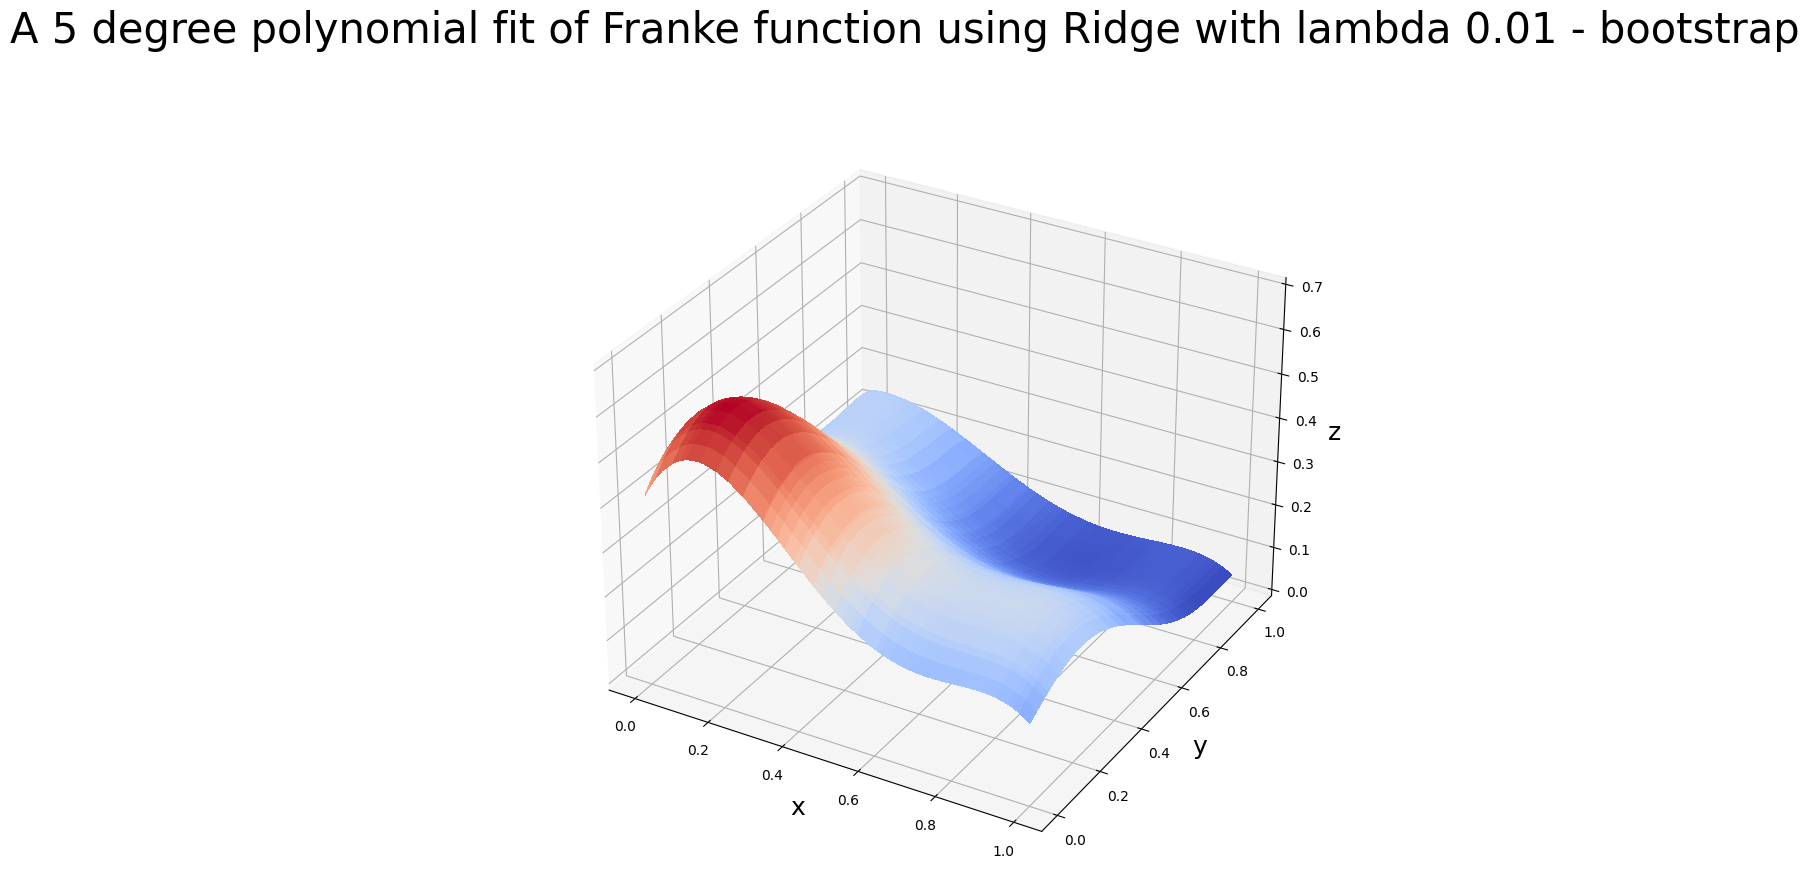

Lamdda: 0.001
MSE: 0.01
R2: 0.88


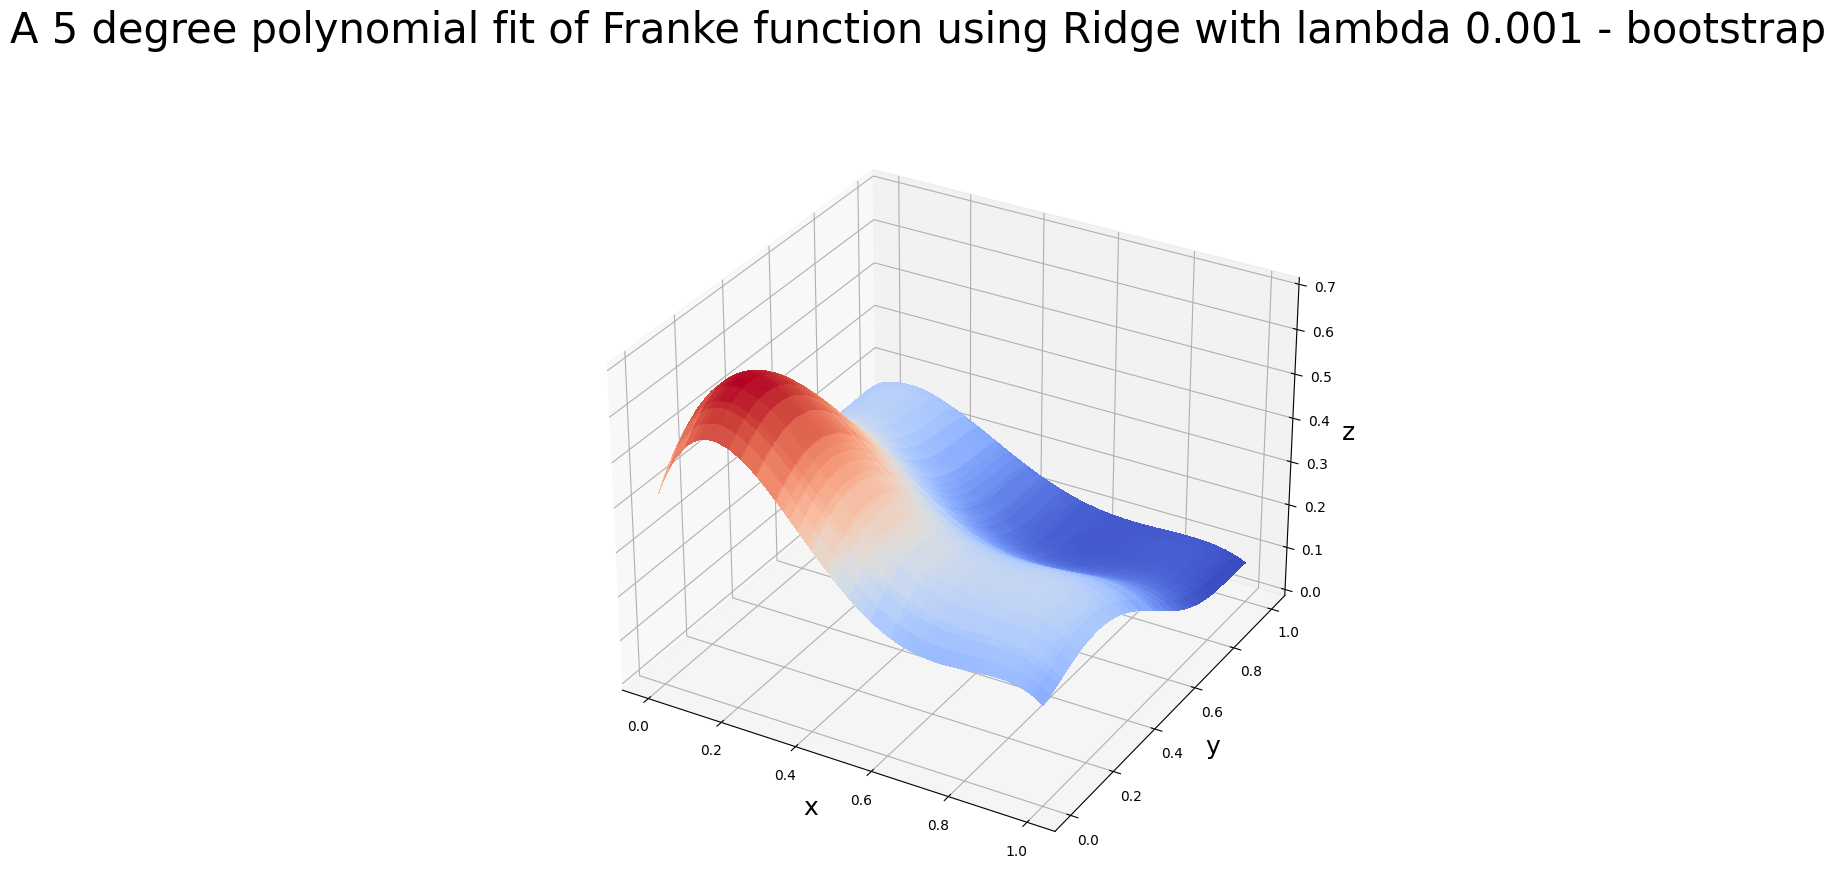

Lamdda: 0.0001
MSE: 0.01
R2: 0.89


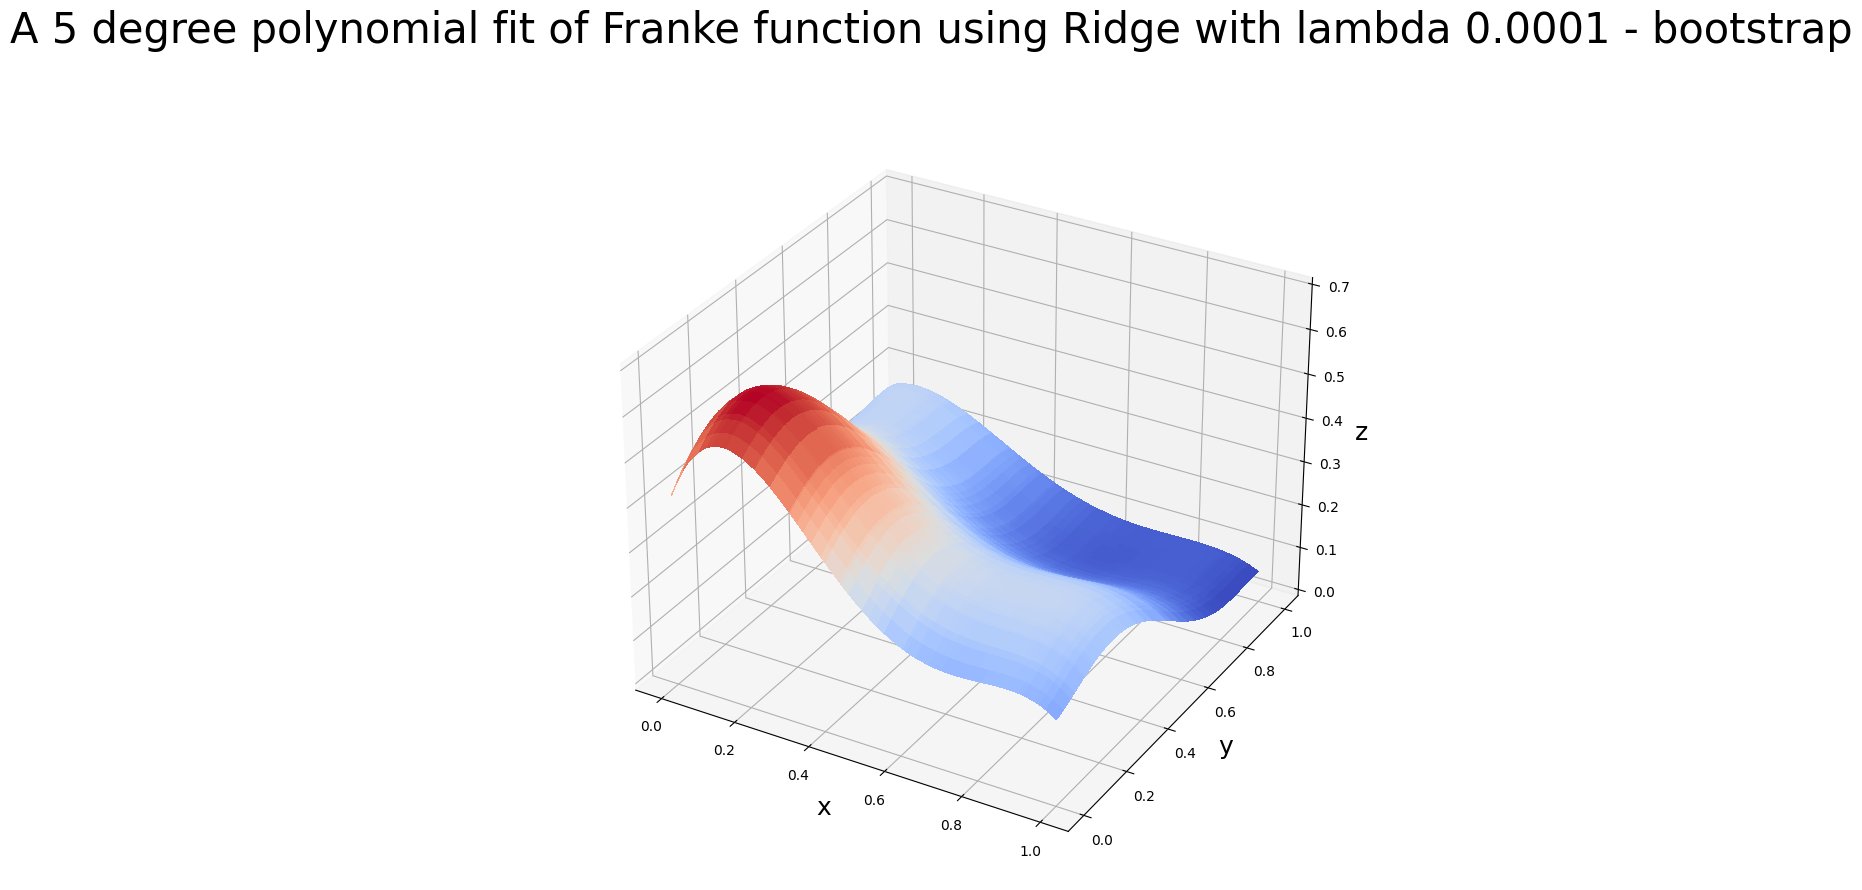

In [1]:
# Common imports
%matplotlib inline

import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.utils import resample
from sklearn import linear_model

def FrankeFunction(x,y):  #Definition of the Franke function
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    noise = np.random.normal(0, 0.1, len(x)*len(x)) 
    noise = noise.reshape(len(x),len(x))
    return term1 + term2 + term3 + term4 + noise

def create_X(x, y, n ):  #creation of the matrix X
    if len(x.shape) > 1:
            x = np.ravel(x)   #gives a 1D array
            y = np.ravel(y)
    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))
    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
    return X

def R2(y_data, y_model):   #function to determine de R2 score of the fit 
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

def MSE(y_data, y_model):  #function to determine the mean squarred error of the fit 
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

N = 100  #Number of data
seed = 31415
np.random.seed(seed)
x = np.sort(np.random.uniform(0, 1, N)) #sort data to plot correctly
y = np.sort(np.random.uniform(0, 1, N))

x, y = np.meshgrid(x,y)  #x et y dim = 2, Creates a grid for the evaluation of the 2 dimension Franke's function
z = FrankeFunction(x, y) #dim =2

x_dim1 = x.ravel() #dim =1
y_dim1 = y.ravel() #dim =1
z_dim1 = z.ravel() #dim =1



#Polynomial order
poly = 5

#creating a list of value for lambda
LAMBDA = [100000,10000,1000, 100,10, 1, 0.1, 0.01, 0.001, 0.0001]

#Total number of lambda
nlambdas = len(LAMBDA)

#Set number of iterations
n_bootstraps=50

#Creating list to store the results 
mean_test_error=[]
mean_train_error=[]
mean_test_r2=[]
mean_train_r2=[]
bias = []
variance = []
bias_variance = []


for j in range (nlambdas): #loop for lambda
    
    #creating list to retrieve results for each lambda value
    testing_error=[]
    training_error =[]
    testing_r2=[]
    training_r2 =[]
    Z_predict=[]
    
    #Getting lambda value
    lmb = LAMBDA[j]
        
    # Create the design matrix
    X = create_X(x_dim1,y_dim1, poly)
    X_train, X_test, z_train, z_test = train_test_split(X,z_dim1,test_size=0.2)
    scaler = StandardScaler()
    scaler.fit(X_train)

    pred = np.empty((int(z_train.shape[0]*0.9), n_bootstraps))
    
    for i in range(n_bootstraps):
        # Bootstrap resampling - leaving out 10% of the data
        X_resampled, z_ = resample(X_train, z_train,n_samples=int(z_train.shape[0]*0.9))
    
        X_train_scaled = scaler.transform(X_resampled)
        X_test_scaled = scaler.transform(X_test)

        # Fit training data with Ridge regression model using SKlearn
        RegRidge = linear_model.Ridge(lmb,fit_intercept=True)
        rdg = RegRidge.fit(X_train_scaled,z_)
    
        #Prediction of the z value using Ridge model
        zpred = rdg.predict(X) #dim = 1
        #Reshaping array without changing the data
        zplot = zpred.reshape(N, N) #dim =2
        
        #filling lists with the result for each bootstrap
        testing_error.append(MSE(z_test, rdg.predict(X_test_scaled)))
        training_error.append(MSE(z_,rdg.predict(X_train_scaled)))
        testing_r2.append(R2(z_test,rdg.predict(X_test_scaled)))
        training_r2.append(R2(z_,rdg.predict(X_train_scaled)))
        Z_predict.append(rdg.predict(X_test_scaled))
        
    print('Lamdda:', lmb)
    print("MSE: {:.2f}".format(MSE(z_test,rdg.predict(X_test_scaled))))
    print("R2: {:.2f}".format(R2(z_test,rdg.predict(X_test_scaled))))
    
    variance.append(np.mean(np.var(Z_predict, axis=0, keepdims=True)))
    bias.append(np.mean( (z_test - np.mean(Z_predict, axis=0, keepdims=True))**2 ))
    bias_variance.append(variance[j]+bias[j])
    mean_test_error.append(np.mean(testing_error))
    mean_train_error.append(np.mean(training_error))
    mean_test_r2.append(np.mean(testing_r2))
    mean_train_r2.append(np.mean(training_r2))
    
    
    #plot result fit
    fig = plt.figure(figsize=(25,10))
    ax = plt.axes(projection='3d')
    ax.set_zlim(0, 0.7)
    ax.set_xlabel('x', fontsize=18)
    ax.set_ylabel('y', fontsize=18)
    ax.set_zlabel('z', fontsize=18)
    fig.suptitle("A {} degree polynomial fit of Franke function using Ridge with lambda {} - bootstrap".format(poly,lmb) ,fontsize="30", color = "black")
    ax.plot_surface(x,y,zplot,cmap=cm.coolwarm,linewidth=0,antialiased=False)
    plt.show()


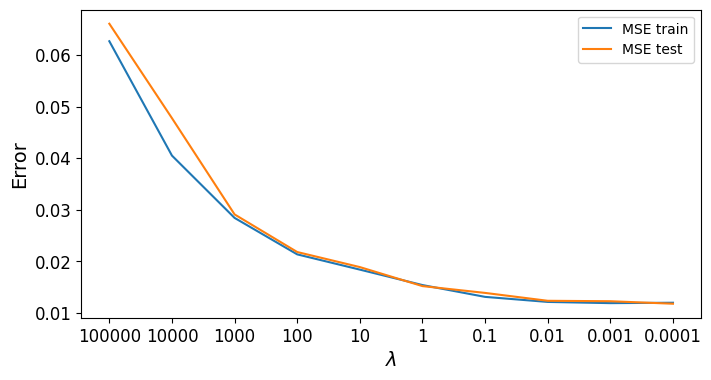

In [2]:
plt.figure(figsize=(8,4))
plt.plot(mean_train_error, label="MSE train")
plt.plot(mean_test_error, label="MSE test")
plt.legend(fontsize = 10)
plt.xticks(ticks=np.arange(len(LAMBDA)),labels=LAMBDA, fontsize=12)
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel("Error", fontsize = 14)
plt.yticks(fontsize=12)
plt.show()

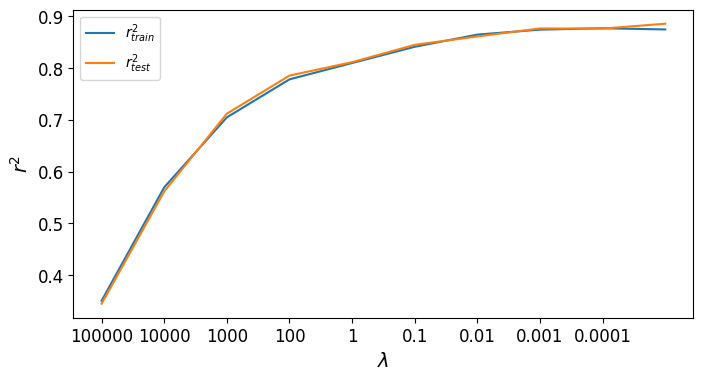

In [3]:
plt.figure(figsize=(8,4))
plt.plot(mean_train_r2, label=r'$r^2_{train}$')
plt.plot(mean_test_r2, label=r'$r^2_{test}$')
plt.legend(fontsize = 10)
plt.xticks([0,1,2,3,4,5,6,7,8],["100000","10000","1000","100","1","0.1","0.01","0.001","0.0001"], fontsize=12)
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel(r'$r^2$', fontsize = 14)
plt.yticks(fontsize=12)
plt.show()

[0.0660494598623491, 0.04773467223376328, 0.029067880926451146, 0.021772988892914992, 0.018846444503429736, 0.015159066468416539, 0.013833783761632855, 0.01230314008902635, 0.012212877699948518, 0.011729413347609111]
[9.884122407746488e-06, 1.0708817529917345e-05, 1.4212196843088686e-05, 1.6981487790290076e-05, 2.3996675547929495e-05, 2.4652843780517754e-05, 2.779738203930998e-05, 3.147567483193144e-05, 3.6704903173580385e-05, 3.6665481004980253e-05]


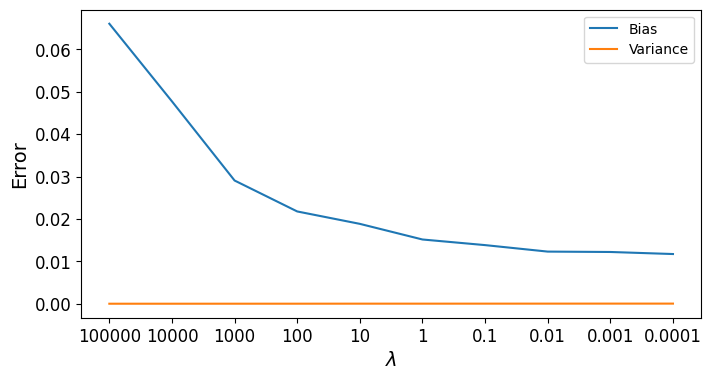

In [4]:
plt.figure(figsize=(8,4))
plt.plot(bias, label="Bias")
print(bias)
plt.plot(variance, label="Variance")
print(variance)
plt.legend(fontsize = 10)
plt.xticks(ticks=np.arange(len(LAMBDA)),labels=LAMBDA, fontsize=12)
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel("Error", fontsize = 14)
plt.yticks(fontsize=12)
plt.savefig("bias_variance_mse_ols_bootstrap_10deg.png", dpi=300)
plt.show()

[0.06605934398475685, 0.047745381051293195, 0.029082093123294236, 0.021789970380705282, 0.018870441178977664, 0.015183719312197056, 0.013861581143672164, 0.01233461576385828, 0.012249582603122098, 0.011766078828614092]
[0.06605934398475684, 0.0477453810512932, 0.02908209312329423, 0.02178997038070528, 0.018870441178977664, 0.01518371931219706, 0.013861581143672166, 0.01233461576385828, 0.012249582603122098, 0.011766078828614093]


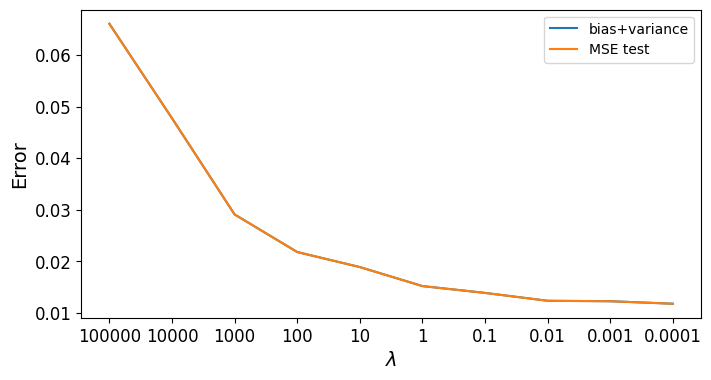

In [5]:
plt.figure(figsize=(8,4))
plt.plot(bias_variance, label="bias+variance")
print(bias_variance)
plt.plot(mean_test_error, label="MSE test")
print(mean_test_error)
plt.legend(fontsize = 10)
plt.xticks(ticks=np.arange(len(LAMBDA)),labels=LAMBDA, fontsize=12)
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel("Error", fontsize = 14)
plt.yticks(fontsize=12)
plt.savefig("bias_variance_error_mse_ols_bootstrap_10deg.png", dpi=300)
plt.show()

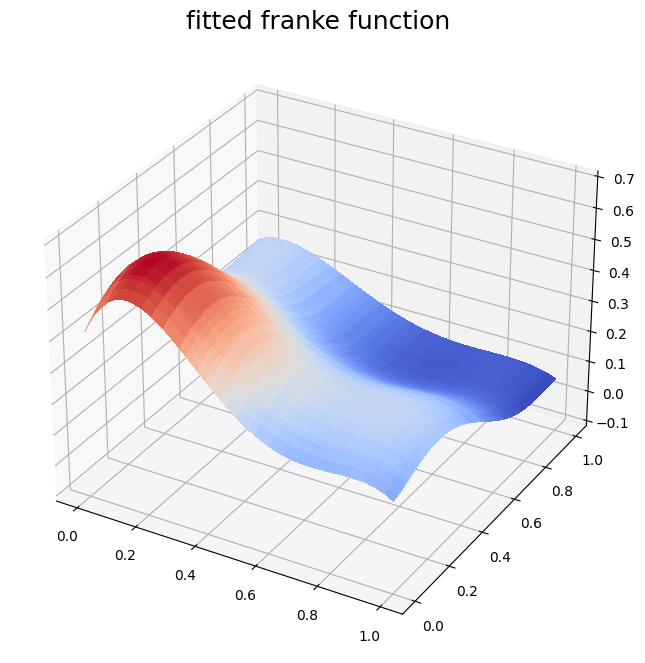

In [6]:
#plot result fit
fig = plt.figure(figsize=(20,8))
ax = plt.axes(projection='3d')
ax.set_zlim(-0.10, 0.7)
ax.plot_surface(x,y,zplot,cmap=cm.coolwarm,linewidth=0,antialiased=False)
ax.set_title('fitted franke function', fontsize=18)
plt.show()

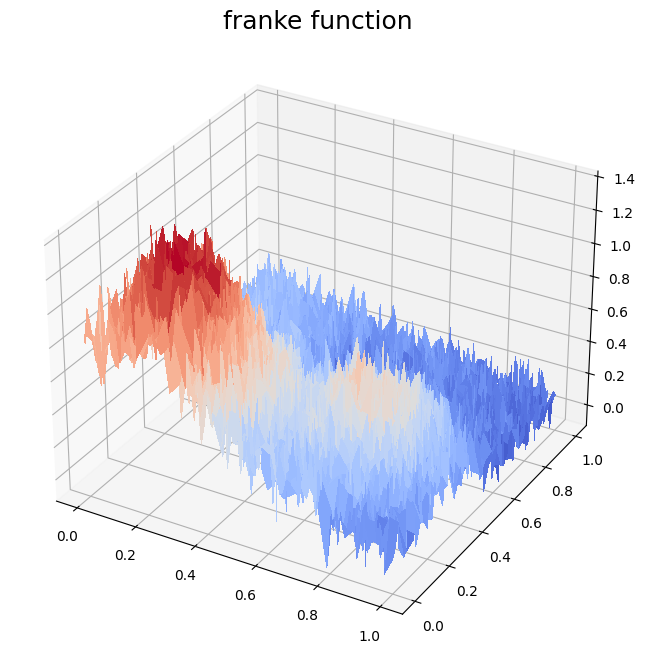

In [7]:
#plot franke function
fig = plt.figure(figsize=(20,8))
ax = plt.axes(projection='3d')
ax.set_zlim(-0.10, 1.40)
ax.plot_surface(x,y,z,cmap=cm.coolwarm,linewidth=0,antialiased=False)
ax.set_title('franke function', fontsize=18)
plt.show()